# Figure 9: Averaged RMSE per sample number for each participant phenotype

## Manuscript Information
 
"Contrast Response Function Estimation with Nonparametric Bayesian Active Learning"  
_Journal of Vision_
https://www.medrxiv.org/content/10.1101/2023.05.11.23289869v2

## Lab and Institution Information

NeuroMedical Informatics Lab  
Washington University in St. Louis

## Figure Description

Displays the mean and standard deviation root-mean-square error (RMSE) values for 12 schizophrenic and 5 neurotypical participants with respect to number of samples. Four conditions were used to sample up to 100 points, namely random with uninformative priors (RUP), random with informative priors (RIP), active with uninformative priors (AUP) and active with informative priors (AIP). Performance of quickCSF on the same estimation tasks is also displayed.

## References

Kalloniatis, Michael, and Charles Luu. “Visual Acuity.” In _Webvision: The Organization of the Retina and Visual System_, edited by Helga Kolb, Eduardo Fernandez, and Ralph Nelson. Salt Lake City (UT): University of Utah Health Sciences Center, 1995. http://www.ncbi.nlm.nih.gov/books/NBK11509/.

Canare, D., Ni, R., & Lu, T. (2019). An open-source implementation of the Quick CSF method. Journal of Vision, 19(10), 86b. https://doi.org/10.1167/19.10.86b

In [1]:
from utility.utils import *
import matplotlib
import matplotlib.pyplot as plt
import gpytorch as gp
import torch as pt
import sys
import seaborn as sns  # statistical plotting library
import json
import datetime
import os
from QuickCSF import simulate

Check versions of python, Gpytorch, and Pytorch dependencies

In [2]:
print("python version -->>", sys.version)
print("gpytorch version -->>", gp.__version__)
print("pytorch version -->>", pt.__version__)

python version -->> 3.10.9 (main, Mar  8 2023, 04:44:36) [Clang 14.0.6 ]
gpytorch version -->> 1.8.1
pytorch version -->> 1.13.1


## Define Constants

In [3]:
# Run-time flags

create_mlcsf_results = False    # run new results for mlcsf?
create_qcsf_results = False     # run new results for qcsf?
make_gif = True                 # save gifs for each run?

verb_mode = False               # print verbose outputs?
plot_figure = True              # plot on screen?
save_plots = True               # save plots in indicated directory?

In [4]:
# MLCSF Constant Declarations

# evaluation grid bounds in raw linear units
# namely, cycles per degree and contrast
raw_freq_min = 0.5
raw_freq_max = 32
raw_contrast_min = 1e-3
raw_contrast_max = 1

# log resolutions of evaulation grid
x_resolution = 15
y_resolution = 30

# for data simulation
generative_random_seed = 2
psi_gamma = .04
psi_lambda = .04
psi_sigma = .08
sigmoid_type = 'logistic'

# ghost points (all labelled as 0s)
raw_freq_ghost_points = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 128]
raw_contrast_ghost_points = [5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 1]

# prior specifications
prior_raw_freq_min = 0.5    # used for scaling
prior_raw_freq_max = 64
prior_raw_contrast_min = 1e-3
prior_raw_contrast_max = 1

scale_factor = 0.4
gaussian_lengthscale = None
prior_model_names = ['textbook'] # TODO: refactor in CSF-23

# ensure needed values are calculated during training
calculate_rmse = True
calculate_entropy = True
calculate_posterior = True
train_after_sampling = False        # train on all data points after sampling?

# number of datapoints
num_halton_samples = 8
num_new_points = 92

# GP hyperparameters
num_initial_points_training_iters = 500
num_new_points_training_iters = 150
beta_for_regularization = .25
min_lengthscale = .15 # Note this changed from .2
lr = .125

# verbose settings
if verb_mode:
    print_training_iters = True        # prints every additional data point
    print_training_hyperparameters = True   # prints lengthscale after each learned GP
    progress_bar = True                # displays progress bar for each GP
else:
    print_training_iters = False        
    print_training_hyperparameters = False   
    progress_bar = False

# number of data points where elapsed time is calculated
timepoints = [10, 20, 50, 100]

# directories + filenames
top_level_results_dir = 'data/'
mlcsf_results_dir = f'{top_level_results_dir}figure_09/'
mlcsf_gif_dir = f'analysis/gifs/figure_09/'

# to load existing results files
mlcsf_filename = 'results_2023-09-23_21-52-17.json'     # used if create_mlcsf_results=False

In [5]:
# qCSF Constant Declarations
# Parameters not listed here are identical to mlcsf when creating qcsf results

qcsf_num_trials = 100
qcsf_random_seed = 2

d = 1   # 1-guess_rate used by qCSF model
qcsf_psi_gammma = 0
qcsf_psi_lambda = 0

# where to save figures
# saved in Figure08 so Exp2 qcsf files all in one place
qcsf_results_dir = f'{top_level_results_dir}qcsf_experiment_2/'
qcsf_gif_dir = f'analysis/gifs/qcsf_experiment_2/'
qcsf_gif_prefix = 'qcsf_'

# loads previous results if create_qcsf_results=False
# make sure qcsf_results_dir + qcsf_filename points to correct file
qcsf_filename = 'results_2023-09-22_16-59-12.json'

In [6]:
# Plotting parameters
%matplotlib inline

title_fontsize = 14     # title font size
label_fontsize = 12     # label font size
tick_fontsize = 10      # tick font size

matplotlib.rcParams['font.family'] = 'Arial'

colors = sns.color_palette('colorblind')

fig_width = 8   # in inches
fig_height = 6  # in inches
dpi = 600       # graphics resolution

x_ticks = [0, 20, 40, 60, 80, 100]
y_ticks = [0, 0.2, 0.4, 0.6, 0.8]

x_axis_min = 0
x_axis_max = 100
y_axis_min = 0
y_axis_max = 0.8


axis_tick_params = {
    'axis':'both', 
    'which':'major', 
    'direction':'out',
    'length': 2
}
std_transparency = 0.2  # transparency for std deviation range
legend_location = 'upper right'

plot_dir = 'analysis/figure_09/'
plot_filename = 'Figure09_NL+SZEfficiency'

# enums
MLCSF, QCSF = 0, 1
SCHIZOPHRENIA = 'Schizophrenia'
NEUROTYPICAL = 'Neurotypical'
SZ = 'SZ'
NT = 'NT'
RESULTS_FIELD = 'Results'

aup_color = 'blue'
aip_color = 'green'
rup_color = 'red'
rip_color = 'orange'
qcsf_color = 'purple'

aup_label = 'AUP'
aip_label = 'AIP'
rup_label = 'RUP'
rip_label = 'RIP'
qcsf_label = 'qCSF'

x_label = 'Sample Count'
y_label = 'RMSE (log10 contrast)'
figure_title = 'Neurotypical and Schizophrenic'

## Create MLCSF Results

In [7]:
# Variables used for all conditions

data_dir = 'data/raw_data/'
data_file_name = 'csf_curves_exp2.json'
data_file_path = f'{data_dir}{data_file_name}'

csf_curves_exp2 = load_json_from_file(data_file_path)

# list of phenotypes with titles
participants = []

for i, thresh in enumerate(csf_curves_exp2['schizophrenia_participants']):
    participants.append((f'{SZ}{i}', thresh))

for i, thresh in enumerate(csf_curves_exp2['neurotypical_participants']):
    participants.append((f'{NT}{i}', thresh))

# setup ghost points
assert len(raw_freq_ghost_points) == len(raw_contrast_ghost_points), "Make sure ghost point arrays have the same length"

ghost_x1 = logFreq().forward(np.array(raw_freq_ghost_points))
ghost_x2 = logContrast().forward(np.array(raw_contrast_ghost_points))
ghost_X = np.vstack((ghost_x1, ghost_x2)).T
ghost_y = np.array([0]*len(ghost_x2))

num_ghost_points = len(ghost_y)

# Transform raw bounds and create grid
x_min = logFreq().forward(raw_freq_min)
x_max = logFreq().forward(raw_freq_max)
y_min = logContrast().forward(raw_contrast_max)  # max and min get flipped when inverting
y_max = logContrast().forward(raw_contrast_min)

grid, xx, yy, xs, ys = create_evaluation_grid_resolution(x_min, x_max, y_min, y_max, x_resolution, y_resolution)

In [8]:
# create results

if create_mlcsf_results:
    results_object = {
        'description': 'description',
        'datetime': datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
        'generative_random_seed': generative_random_seed,
    }
    print('datetime =', results_object['datetime'])

    for title, curve in participants:

        ###################
        # CONSTRUCT CURVE #
        ###################
        set_random_seed(generative_random_seed)

        curve = np.array(curve)
        # prepare freqs - turn log10 to log2, and start from 0
        curve[:, 0] = (np.log2(10) * curve[:, 0]) - np.log2(.125)
        left, right, bottom, top = get_data_bounds(curve)

        cs = create_cubic_spline(curve)

        ################
        # TRAIN MODELS #
        ################

        # define how to transform the data
        prior_freq_min = logFreq().forward(prior_raw_freq_min)
        prior_freq_max = logFreq().forward(prior_raw_freq_max)
        prior_contrast_min = logContrast().forward(prior_raw_contrast_max) # 1/x swaps min and max
        prior_contrast_max = logContrast().forward(prior_raw_contrast_min)

        def f(d):
            return scale_data_within_range(d, (0, 1), prior_freq_min, prior_freq_max, prior_contrast_min, prior_contrast_max)

        # create initial data points
        halton_X, halton_y = halton_samples_from_data(xx, yy, cs, psi_gamma, psi_lambda, num_halton_samples, sigmoid_type = sigmoid_type, psi_sigma = psi_sigma)
            
        initial_Xs = np.vstack((ghost_X, halton_X))
        initial_ys = np.hstack((ghost_y, halton_y))
        
        num_initial_points = len(initial_ys)

        param_dicts = []

        for prior_model_name in prior_model_names:
            param_dict = {
                'state_dict_path': f'data/priors/prior_mean_model_state_{prior_model_name}.pth',
                'Xt_path': f'data/priors/prior_mean_model_Xt_{prior_model_name}.pth',
                'scale_factor': scale_factor,
                'gaussian_lengthscale': gaussian_lengthscale,
                'min_lengthscale': min_lengthscale,
                'psi_gamma': psi_gamma,
                'psi_lambda': psi_lambda,
            }
            param_dicts.append(param_dict) 

        # create base params used for all conditions
        base_params = {
            "cs": cs,
            "grid": grid,
            "xx": xx,
            "yy": yy,
            "psi_sigma": psi_sigma,
            "sigmoid_type": sigmoid_type,
            "psi_gamma": psi_gamma,
            "psi_lambda": psi_lambda,
            "lr": lr,
            "num_initial_training_iters": num_initial_points_training_iters,
            "num_new_points_training_iters": num_new_points_training_iters,
            "num_new_points": num_new_points,
            "beta_for_regularization": beta_for_regularization,
            "train_on_all_points_after_sampling": train_after_sampling,
            "phi": f,
            "print_training_hyperparameters": print_training_hyperparameters,
            "print_training_iters": print_training_iters,
            "progress_bar": progress_bar,
            "min_lengthscale": min_lengthscale,
            "calculate_rmse": calculate_rmse,
            "calculate_entropy": calculate_entropy,
            "calculate_posterior": calculate_posterior,
            "initial_Xs": initial_Xs,
            "initial_ys": initial_ys,
            "num_ghost_points": num_ghost_points,
            "timepoints": timepoints
        }

        # now train on the threshold
        random_seed = generative_random_seed
        
        print(f'{title}')

        active_rmse = []
        random_rmse = []
        aprior_rmse = []
        rprior_rmse = []

        ##########
        # ACTIVE #
        ##########
        
        set_random_seed(random_seed)

        _, _, X_active, y_active, active_rmse_list, _, active_posterior_list, active_times = sample_and_train_gp(
            sampling_strategy='active',
            mean_module_name='constant_mean',
            **base_params
        )

        active_results_dict = {
            'xx': xx,
            'yy': yy,
            'X': X_active,
            'y': y_active,
            'left': left,
            'right': right,
            'top': top,
            'bottom': bottom,
            'cs': cs,
            'psi_sigma': psi_sigma,
            'sigmoid_type': sigmoid_type,
            'psi_gamma': psi_gamma,
            'psi_lambda': psi_lambda,
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'xs': xs,
            'ys': ys,
            'grid': grid,
            'f': f,
            'posterior_list': active_posterior_list,
        }

        ntitle = title.replace(' ', '_')
        save_plot_path = mlcsf_gif_dir + f'{results_object["datetime"]}/active/{ntitle}/'

        if make_gif:
            create_and_save_plots(active_results_dict, save_plot_path, ntitle, start_index=num_ghost_points)
            create_gif(save_plot_path)

        ##########
        # RANDOM #
        ##########
        
        set_random_seed(random_seed)

        _, _, X_random, y_random, random_rmse_list, random_posterior_list, random_times = sample_and_train_gp(
            sampling_strategy='random',
            mean_module_name='constant_mean',
            **base_params
        )

        random_results_dict = {
            'xx': xx,
            'yy': yy,
            'X': X_random,
            'y': y_random,
            'left': left,
            'right': right,
            'top': top,
            'bottom': bottom,
            'cs': cs,
            'psi_sigma': psi_sigma,
            'sigmoid_type': sigmoid_type,
            'psi_gamma': psi_gamma,
            'psi_lambda': psi_lambda,
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'xs': xs,
            'ys': ys,
            'grid': grid,
            'f': f,
            'posterior_list': random_posterior_list,
        }

        ntitle = title.replace(' ', '_')
        save_plot_path = mlcsf_gif_dir + f'{results_object["datetime"]}/random/{ntitle}/'

        if make_gif:
            create_and_save_plots(random_results_dict, save_plot_path, ntitle, start_index=num_ghost_points)
            create_gif(save_plot_path)

        ##########
        # APRIOR #
        ##########
        
        set_random_seed(random_seed)

        _, _, X_aprior, y_aprior, aprior_rmse_list, _, aprior_posterior_list, aprior_times = sample_and_train_gp(
            sampling_strategy='active',
            mean_module_name='prior_gp_mean',
            mean_module_params=param_dicts,
            **base_params
        )

        aprior_results_dict = {
            'xx': xx,
            'yy': yy,
            'X': X_aprior,
            'y': y_aprior,
            'left': left,
            'right': right,
            'top': top,
            'bottom': bottom,
            'cs': cs,
            'psi_sigma': psi_sigma,
            'sigmoid_type': sigmoid_type,
            'psi_gamma': psi_gamma,
            'psi_lambda': psi_lambda,
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'xs': xs,
            'ys': ys,
            'grid': grid,
            'f': f,
            'posterior_list': aprior_posterior_list,
        }

        ntitle = title.replace(' ', '_')
        save_plot_path = mlcsf_gif_dir + f'{results_object["datetime"]}/aprior/{ntitle}/'

        if make_gif:
            create_and_save_plots(aprior_results_dict, save_plot_path, ntitle, start_index=num_ghost_points)
            create_gif(save_plot_path)

        ##########
        # RPRIOR #
        ##########
        
        set_random_seed(random_seed)

        _, _, X_rprior, y_rprior, rprior_rmse_list, rprior_posterior_list, rprior_times = sample_and_train_gp(
            sampling_strategy='random',
            mean_module_name='prior_gp_mean',
            mean_module_params=param_dicts,
            **base_params
        )

        rprior_results_dict = {
            'xx': xx,
            'yy': yy,
            'X': X_rprior,
            'y': y_rprior,
            'left': left,
            'right': right,
            'top': top,
            'bottom': bottom,
            'cs': cs,
            'psi_sigma': psi_sigma,
            'sigmoid_type': sigmoid_type,
            'psi_gamma': psi_gamma,
            'psi_lambda': psi_lambda,
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'xs': xs,
            'ys': ys,
            'grid': grid,
            'f': f,
            'posterior_list': rprior_posterior_list,
        }

        ntitle = title.replace(' ', '_')
        save_plot_path = mlcsf_gif_dir + f'{results_object["datetime"]}/rprior/{ntitle}/'

        if make_gif:
            create_and_save_plots(rprior_results_dict, save_plot_path, ntitle, start_index=num_ghost_points)
            create_gif(save_plot_path)

        ##########
        # SAVING #
        ##########

        for i in range(num_halton_samples + num_new_points):
            active_rmse.append((i, active_rmse_list[i]))
            random_rmse.append((i, random_rmse_list[i]))
            aprior_rmse.append((i, aprior_rmse_list[i]))
            rprior_rmse.append((i, rprior_rmse_list[i]))

        exp_results = {
            'random_seed': random_seed,
            'active_rmse': active_rmse,
            'random_rmse': random_rmse,
            'aprior_rmse': aprior_rmse,
            'rprior_rmse': rprior_rmse,
            'active_times': active_times,
            'random_times': random_times,
            'aprior_times': aprior_times,
            'rprior_times': rprior_times,
        }

        if RESULTS_FIELD not in results_object:
            results_object[RESULTS_FIELD] = [exp_results]
        else:
            results_object[RESULTS_FIELD].append(exp_results)

        # save after each participant
        mlcsf_filename = f'results_{results_object["datetime"]}.json'
        ensure_directory_exists(mlcsf_results_dir)
        with open(mlcsf_results_dir + mlcsf_filename, 'w') as file:
            json.dump(results_object, file, indent=2)
else:
    print("No MLCSF results have been run...")


No MLCSF results have been run...


## Create qCSF Results

In [9]:
# RUN QCSF

if create_qcsf_results:
    # parameters to run QuickCSF simulation
    simulationParams = {
        'trials': qcsf_num_trials,
        'stimuli': {
            'minContrast': raw_contrast_min,
            'maxContrast': raw_contrast_max,
            'contrastResolution': xs,
            'minFrequency': raw_freq_min,
            'maxFrequency': raw_freq_max,
            'frequencyResolution': ys,
        },
        'parameters': None,
        'd': d,             
        'psiGamma': qcsf_psi_gammma,
        'psiLambda': qcsf_psi_lambda,
        'psiSigma': psi_sigma,
        "sigmoidType": sigmoid_type,
        'timepoints': timepoints,
        'showPlots': False  # prevents plt from plotting every run 
    }

    # setup directories
    qcsf_timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    gifPath = f"{qcsf_gif_dir}{qcsf_gif_prefix}{qcsf_timestamp}/"
    if not os.path.exists(qcsf_results_dir): os.mkdir(qcsf_results_dir)
    print("Timestamp:", qcsf_timestamp)

    resultsObject = {
        'datetime': qcsf_timestamp,
        **simulationParams
    }

    for participant_label, participant in participants:
        print(f"Participant {participant_label}")

        curve = np.array(participant)
        imagePath = f"{gifPath}{participant_label}/" if make_gif else None

        rmses, times, params = simulate.runSimulation(
            trueThresholdCurve=curve,
            imagePath=imagePath,
            randomSeed=qcsf_random_seed,
            **simulationParams)

        expResults = {
        "random_seed": qcsf_random_seed,
        "rmses": rmses,
        "times": times,
        "params": params, 
        }

        if participant_label not in resultsObject:
            resultsObject[participant_label] = [expResults]
        else:
            resultsObject[participant_label].append(expResults)

        if make_gif: create_gif(imagePath)

        qcsf_filename = f'results_{qcsf_timestamp}.json'
        ensure_directory_exists(qcsf_results_dir)
        with open(qcsf_results_dir + qcsf_filename, 'w') as file:
            json.dump(resultsObject, file, indent=2)
else:
    print("No qCSF results have been run...")

No qCSF results have been run...


## Plotting

In [10]:
# Calculate qCSF mean and standard deviation per sample

# load qcsf results
with open(qcsf_results_dir + qcsf_filename, 'r') as file:
    qcsf_results_object = json.load(file)

# calculate RMSE for qCSF
num_trials = qcsf_results_object["trials"]
qcsf_rmses = np.zeros((len(participants), num_trials))

for i, (participant_label, _) in enumerate(participants):
    qcsf_rmses[i,:] = qcsf_results_object[participant_label][0]['rmses']

qcsf_mean = np.mean(qcsf_rmses, axis=0)
qcsf_std = np.std(qcsf_rmses, axis=0)

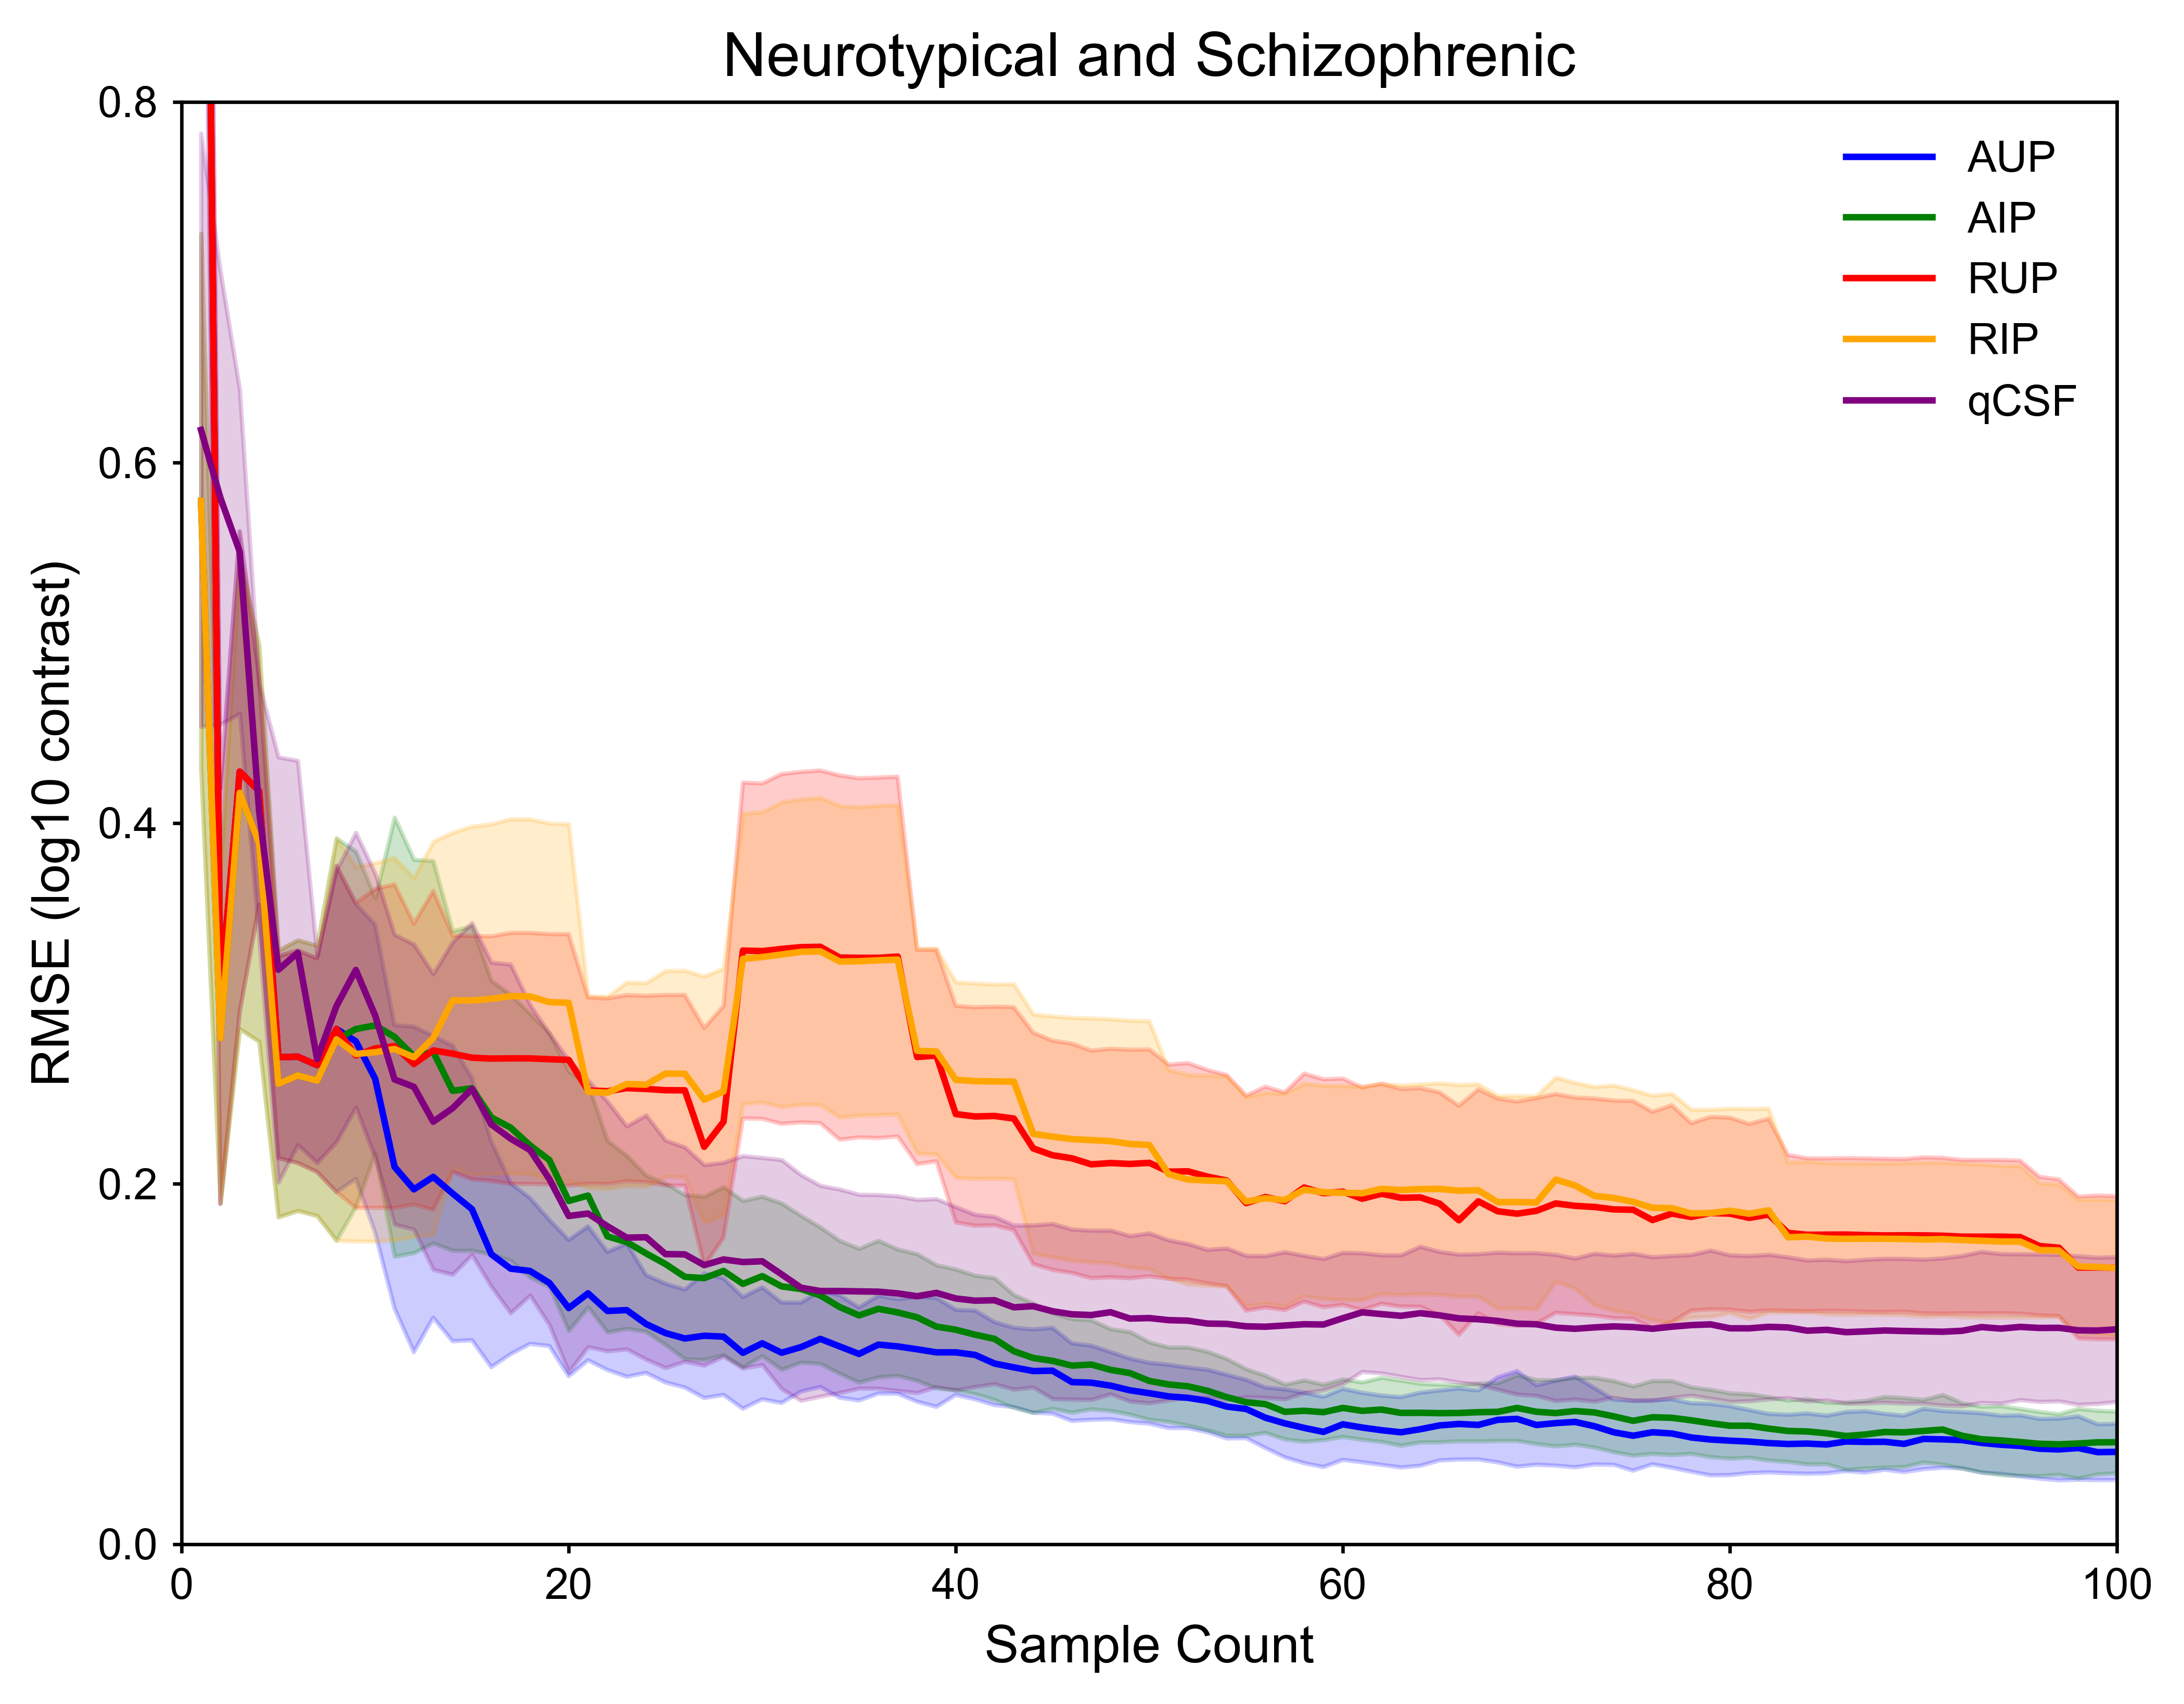

In [ ]:
# calculate and plot MLCSF mean and std per sample

# plot only shows if plt.show() is called
plt.ioff()

# get mlcsf results
with open(mlcsf_results_dir + mlcsf_filename, 'r') as file:
    results_object = json.load(file)

Figure09_datetime = results_object['datetime']
random_seed = results_object['generative_random_seed']

##################
# PLOTTING MLCSF #
##################

# dictionary of settings for each condition, namely...
# key: label, color, model_type
conditions = {
    'active_rmse': (aup_label, aup_color),
    'aprior_rmse': (aip_label, aip_color),
    'random_rmse': (rup_label, rup_color),
    'rprior_rmse': (rip_label, rip_color)
}

plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

# for condition, (label, color, model) in conditions.items():
for condition, (label, color) in conditions.items():

    all_participants = results_object[RESULTS_FIELD]
    num_datapoints = len(all_participants[0][condition])
    all_rmses = np.zeros((len(all_participants), num_datapoints))

    # add each participant to a row
    for i, participant in enumerate(all_participants):
        _, all_rmses[i,:] = zip(*participant[condition]) # stored as (iteration_number, rmse)

    mean = np.mean(all_rmses, axis=0) 
    std = np.std(all_rmses, axis=0)
    
    # plot the mean
    sample_count = np.arange(1, num_datapoints+1) # 1-indexed
    plt.plot(sample_count, mean, label=label, color=color)

    # calculate the +/- std values
    upper = mean + std
    lower = mean - std

    # plot the shaded regions
    plt.fill_between(sample_count, upper, lower, alpha=std_transparency, color=color)

#################
# PLOTTING QCSF #
#################

# mean
qcsf_num_pts = np.arange(1,num_trials+1)    # 1-indexed
plt.plot(qcsf_num_pts, qcsf_mean, label=qcsf_label, color=qcsf_color)

# get upper and lower for standrd deviation
qcsf_upper = qcsf_mean + qcsf_std
qcsf_lower = qcsf_mean - qcsf_std
plt.fill_between(qcsf_num_pts, qcsf_upper, qcsf_lower, alpha=std_transparency, color=qcsf_color)

#################
# PLOT SETTINGS #
#################

plt.xlabel(x_label, fontsize=label_fontsize)
plt.ylabel(y_label, fontsize=label_fontsize)
plt.legend(loc=legend_location, frameon=False)

plt.tick_params(**axis_tick_params, labelsize=tick_fontsize)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlim(x_axis_min, x_axis_max)
plt.ylim(y_axis_min, y_axis_max)

plt.title(figure_title, fontsize=title_fontsize)

# show the plot
if save_plots:
    ensure_directory_exists(plot_dir)
    plt.savefig(f'{plot_dir}{plot_filename}.png', bbox_inches='tight', dpi=dpi)
    plt.savefig(f'{plot_dir}{plot_filename}.pdf', bbox_inches='tight', dpi=dpi)
if plot_figure: plt.show()